# Multi-level regression modeling, baby one more time

This notebook provides an introduction to multi-level regression modeling
using [Stan](https://mc-stan.org) and the [CmdStanPy](https://mc-stan.org/cmdstanpy/) interface,
a pure Python3 package for Linux, MacOS, and Windows.
It is based on Chris Fonnesbeck's excellent [A Primer on Bayesian Multilevel Modeling using PyStan](https://mc-stan.org/users/documentation/case-studies/radon.html), which was developed as part of a [Stan workshop](https://statmoddev.stat.columbia.edu/2016/06/09/a-primer-on-bayesian-multilevel-modeling-using-pystan/)  for biomedical statisticians at Vanderbilt University.
The data and models are taken from chapter 12 of the book _Data Analysis Using Regression and Multilevel/Hierarchical Models_, by Andrew Gelman and Jennifer Hill, Cambridge university press, 2006.

A secondary aim of this notebook is to demonstrate best practices of Bayesian data analysis,
which entails careful summaries and visualization of the data, models, and resulting inferences.
To visualize data and inference results we use
[plotnine](https://plotnine.readthedocs.io/en/stable/),
an implementation of a [_grammar of graphics_](https://vita.had.co.nz/papers/layered-grammar.pdf) in Python, based on [ggplot2](https://en.wikipedia.org/wiki/Ggplot2).

In [1]:
# import all libraries used in this notebook
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from cmdstanpy import CmdStanModel

# setup plot look and feel
theme_set(
  theme_grey() + 
  theme(text=element_text(size=10),
        plot_title=element_text(size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8)
       )
)
flip_xlabels = theme(axis_text_x = element_text(angle=90, hjust=1))

The radon data may sometimes trigger spurious warnings from plotnine and CmdStanPy, which we will ignore.  During model development we recommend leaving CmdStanPy logging level at `logging.WARNING`.

In [2]:
# suppress plotnine warnings
import warnings
warnings.filterwarnings('ignore')

# suppress CmdStanPy warnings
import logging
from cmdstanpy.utils import get_logger
logger = get_logger().setLevel(logging.ERROR)

## Modeling goal: home radon measurement

Applied statistical modeling starts with the question we are trying to answer and the available data.
We must understand both the data and the analysis goals before proceeding to model building.

The goal of the radon study is to provide reasonable estimates
of home radon levels in each of the approximately 3000 counties in the United States.
Gelman and Hill write

>Radon is a carcinogen — a naturally occurring radioactive gas whose decay products are also radioactive — known to cause lung cancer in high concentrations and estimated to cause several thousand lung cancer deaths per year in the United States. The distribution of radon levels in U.S. homes varies greatly, with some houses having dangerously high concentrations. In order to identify the areas with high radon exposures, the Environmental Protection Agency coordinated radon measurements in a random sample of more than 80,000 houses throughout the country.

[Radon gas](https://en.wikipedia.org/wiki/Radon) is a product of the slow decay of uranium into lead.  Due to local differences in geology, the level of exposure to radon gas differs from place to place. A common source is uranium-containing minerals in the ground, and therefore it accumulates in subterranean areas such as basements.

![How radon enters the home](img/radon_entry.jpg)
Image from https://www.health.state.mn.us/communities/environment/air/radon/index.html

The [EPA radon map](https://www.epa.gov/sites/default/files/2015-07/documents/zonemapcolor.pdf) shows the counties of the US, color coded by radon level - red for the highest risk, orange for moderate, and yellow for low.

![EPA radon map](img/epa_radon_map.png)

## Study data:  item-level radon, county-level soil uranium levels

The data comes from EPA surveys at the state and national level carried out in the 1990s.
It is available from the Gelman and Hill [ARM website](http://www.stat.columbia.edu/~gelman/arm/examples/radon/), together with the R scripts used to produce the examples in the book.
The study data is in two files.

- Home radon measurements, and the floor (ground or basement) where measured from an EPA survey conducted in 1992.
The survey data is in file http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat.

- County level measurements of soil uranium levels in parts per million.
The soil uranium data is in file http://www.stat.columbia.edu/~gelman/arm/examples/radon/cty.dat


We have downloaded and renamed these files.
File `srrs2.dat` is available as  [data/raw_radon.csv](data/raw_radon.csv) and
file `cty.dat` is available as [data/raw_uranium.csv](data/raw_uranium.csv).
These names are informative and will sort together in a directory listing.
The full EPA dataset has been [archived separately](http://www.stat.columbia.edu/~gelman/arm/examples/radon_complete/).

There are a total of 120K home radon measurements from 3000 US counties.
The per-county measurements follow the population density; there are few or no measurements
for sparsely populated counties, i.e. rural counties and correspondingly more for metropolitan counties.

**Data preprocessing required by this analysis**

We need to extract and combine that subset of the information in these tables into the dataset required for this analysis.
The essential pre-processing steps are

1. Merge the county-level soil uranium level measurment into the house-level radon data.

2. Put both outcome and predictors on the log scale, following Gelman and Hill, chapter 4, section 12.

3. Restrict the dataset to Minnesota.

4. Get counts of observations per county.

Appendix A lists the exact pre-processing steps used here.
The results are in two files

+ [data/mn_radon.csv](data/mn_radon.csv) contains the individual home radon measurments.
+ [data/mn_counties.csv](data/mn_counties.csv) contains county-level data.

In [3]:
mn_radon = pd.read_csv(os.path.join('data','mn_radon.csv'))
mn_radon[:7]

,state,floor,county,log_radon,log_uranium,county_code
0,MN,1,AITKIN,0.788457,-0.689048,1
1,MN,0,AITKIN,0.788457,-0.689048,1
2,MN,0,AITKIN,1.064711,-0.689048,1
3,MN,0,AITKIN,0.000000,-0.689048,1
4,MN,0,ANOKA,1.131402,-0.847313,2
5,MN,0,ANOKA,0.916291,-0.847313,2
6,MN,0,ANOKA,0.405465,-0.847313,2


In [4]:
mn_counties = pd.read_csv(os.path.join('data','mn_counties.csv'))
mn_counties[:3]

,state,county,log_uranium,county_code,obs
0,MN,AITKIN,-0.689048,1,4
1,MN,ANOKA,-0.847313,2,52
2,MN,BECKER,-0.113459,3,3


## Best Practice #1: preliminary data analysis

A sometimes overlooked issue when doing model criticism and model comparison is the fact that we are evaluating the fit of the model _to the data_.  The size and shape of the data informs our choice of model.  Finally, the data collected is not always the data expected.  Therefore we start with plots and summaries of the raw data.

**First questions: amount of data, variable of interest**

As noted as the outset, the measurements per county vary with the population density.  Therefore a logical first question is:  how much data is there for Minnesota?

In [5]:
print(f'number of houses: {len(mn_radon)}')
print(f'number of counties: {len(mn_counties)}')

number of houses: 919
number of counties: 85


The goal of our analysis is to estimate home radon levels; therefore the outcome variable of interest is `log_radon`.
We use the [pandas.DataFrame.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function to get summary statistics over the observed outcome `log_radon`.

In [6]:
print(f'log_radon summary statistics\n{mn_radon["log_radon"].describe()}')

log_radon summary statistics
count    919.000000
mean       1.224623
std        0.853327
min       -2.302585
25%        0.641854
50%        1.280934
75%        1.791759
max        3.875359
Name: log_radon, dtype: float64


**Relationship between radon and floor**

As the radon pathways diagram shows, radon comes from the soil, therefore the floor level on which the measurement was taken should be a good predictor of the observed radon level. This is coded as "0" for basement and "1" for ground floor level.  Most of the homes in the survey have a basement level.

In [7]:
pct_1 = round((mn_radon.floor.sum() / len(mn_radon) * 100))
pct_0= round(100 - pct_1)
print(f'floor 0: {pct_0}%\nfloor 1: {pct_1}%')

floor 0: 83%
floor 1: 17%


The [plotnine geom_histogram](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_histogram.html) provides a visualization of the distribution of home radon measurements in the survey dataset.
We use plotnine's [facet_grid](https://plotnine.readthedocs.io/en/stable/generated/plotnine.facets.facet_grid.html#plotnine.facets.facet_gridplot ) to make separate plots for measurements taken in the basement level (floor 0) and ground floor level (floor 1).
The histograms clearly show the different amounts of observation (y axis), but the trend in log radon levels (x axis) is unclear.

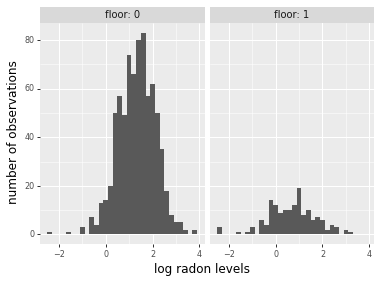

<ggplot: (8785550101694)>

In [8]:
(ggplot(mn_radon, aes(x='log_radon'))
    + geom_histogram(binwidth=0.2)
    + xlab("log radon levels") + ylab("number of observations")
    + theme(figure_size=(10,4))
    + facet_grid(facets='~ floor', labeller='label_both')
)

The plotnine [plotnine geom_point](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_point.html) plots two variables as (x, y) points.  In the following plots, we always plot `log_radon` on the y axis, since it is the outcome variable of interest for this case study.

We plot the log_radon levels by floor and add jitter to see the relative difference in the measurements and number of observations taken by floor.  The plot also shows that there are far more measurements taken in the basement than on the ground floor.  It suggests that radon measurements are higher in the basement than on the ground floor.

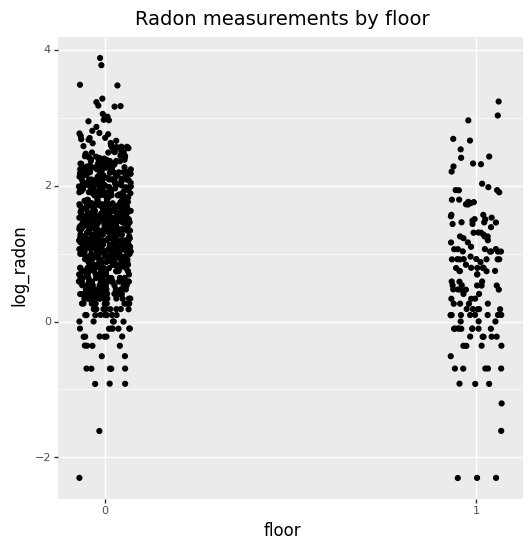

<ggplot: (8785600197087)>

In [9]:
plot_radon_floor = (ggplot(mn_radon, aes(x='floor', y='log_radon')) 
    + geom_jitter(width=0.07) + theme(figure_size=(6,6))
    + ggtitle("Radon measurements by floor")
    + scale_x_continuous(breaks=range(0,2), minor_breaks=[])
)
plot_radon_floor

**County-level information: number of observations, soil uranium**

At the county level we have many home radon measurements from the relatively few counties with metropolitan areas, and very few home radon measurements from the rest.

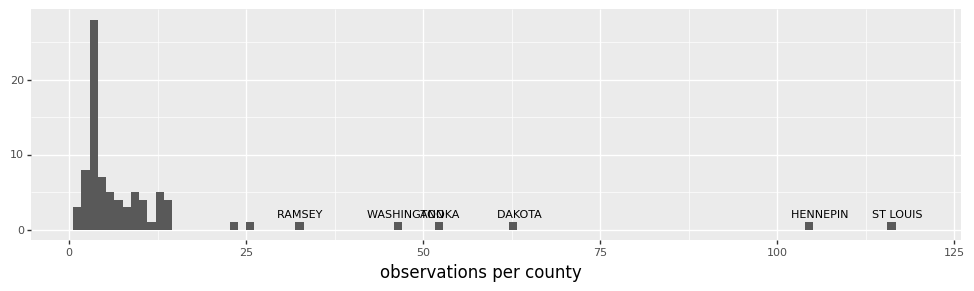

<ggplot: (8785567743796)>

In [10]:
(ggplot(mn_counties)
    + geom_histogram(aes('obs'), bins=100)
    + theme(figure_size=(12,3))
    + ylab("") + xlab("observations per county")
    + geom_text(mn_counties[mn_counties['obs'] > 25], aes(x='obs', y=2, label='county'), size=8,
               nudge_x=4, nudge_y=0.1)
)

We use the [plotnine.geom_boxplot](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_boxplot.html#plotnine.geoms.geom_boxplot)
to generate a [box_and_whiskers plot](https://en.wikipedia.org/wiki/Box_plot) for each set of per-county radon measurements.  The width of the box is proportional to the square root of the number of observations.
As the counties are ordered by number of observations, the width of the boxes increases from left to right.
The box encloses the central 25% - 75% quantiles; this is the 
[interquartile range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range).
The the whiskers extend to the values which are a distance of 1.5 the IQR, and values beyond that are plotted as points - these are the outliers.

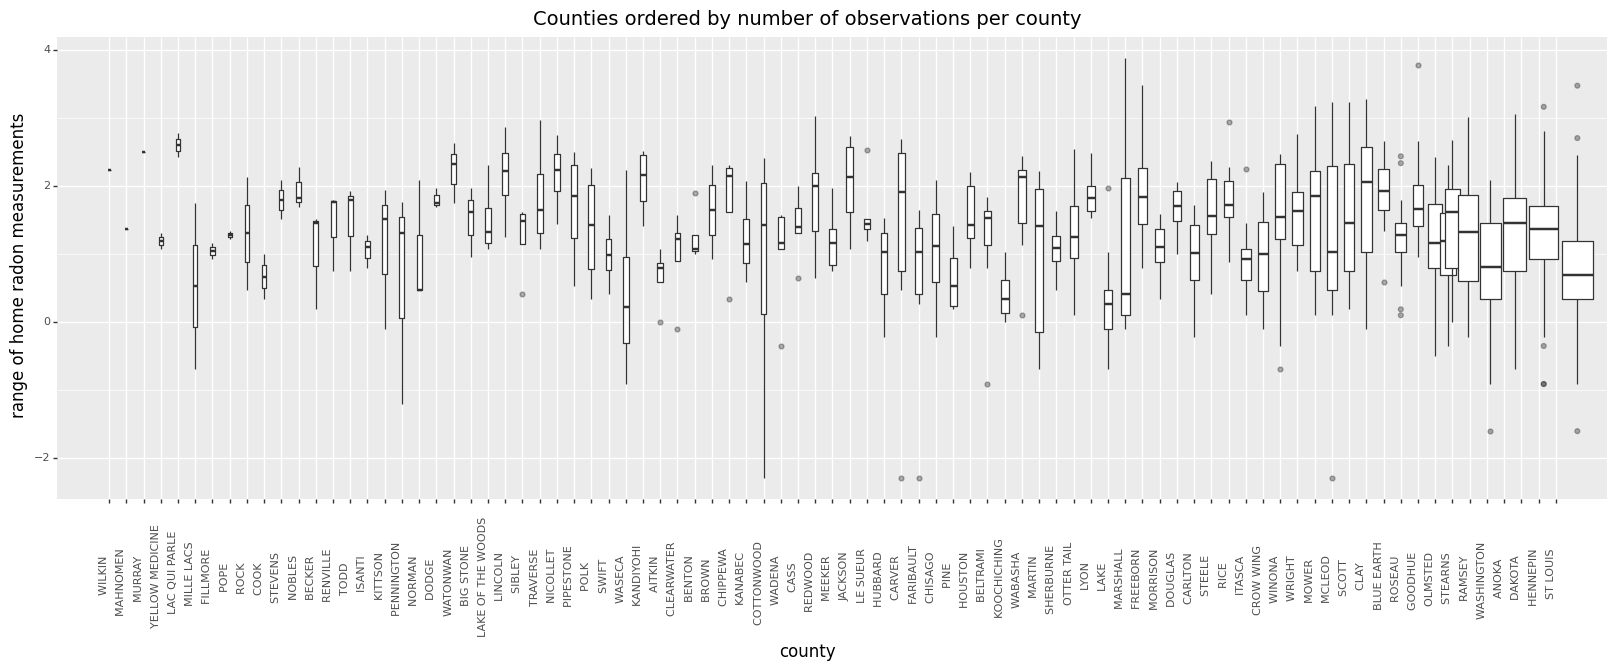

<ggplot: (8785550120572)>

In [11]:
obs = mn_counties.sort_values(by='obs').reset_index()

(ggplot(mn_radon, aes(x='county',y='log_radon'))
    + geom_boxplot(width=2, varwidth=True, outlier_alpha=0.4)
    + scale_x_discrete(limits=obs['county'], expand=(0,3)) +  flip_xlabels
    + ggtitle("Counties ordered by number of observations per county")
    + ylab("range of home radon measurements")
    + theme(figure_size=(20, 6))
)

**Relationship between home radon and county-level soil uranium**

At the county-level, we have information on the soil uranium level.  We plot the number of observations by soil uranium.  The points on the x-axis line up with the histogram bars on the above plot, but instead of histogram bars, we have a series of points showing the different log_uranium levels.

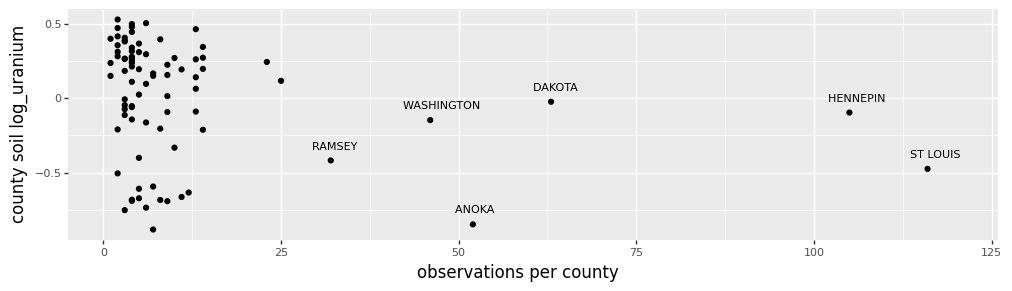

<ggplot: (8785582358486)>

In [12]:
# plot, keeping uranium level on y axis
(ggplot(mn_counties, aes(x='obs', y='log_uranium'))
    + geom_point()
    + geom_text(mn_counties[mn_counties['obs']>25], aes(label='county'),  size=8, nudge_x=4, nudge_y=0.1)
    + ylab("county soil log_uranium") + xlab("observations per county")
    + theme(figure_size=(12,3))
)

We plot the relationship between soil uranium level and the home radon measurement, faceted by floor.
Because the soil uranium level measurement is the same for all homes in a county, for counties with many houses, i.e., metropolitan areas, the plot shows distinct vertical bands.

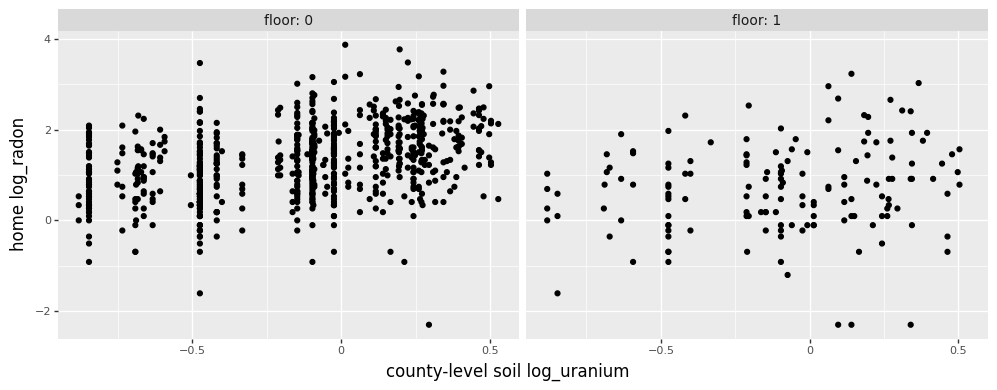

<ggplot: (8785600171322)>

In [13]:
ggplot(mn_radon, aes('log_uranium', 'log_radon')) + geom_point() +\
    ylab("home log_radon") + xlab("county-level soil log_uranium") + theme(figure_size=(12,4)) +\
    facet_grid(facets='~ floor', labeller='label_both')

To see whether or not the soil uranium level might be a good predictor of the home radon measurements,
we can repeat the above boxplot, this time ordering the counties on the x-axis by
the per-county activity levels, ordered by uranium level per county, descending.


Given the sparse data, the resulting plot is inconclusive.

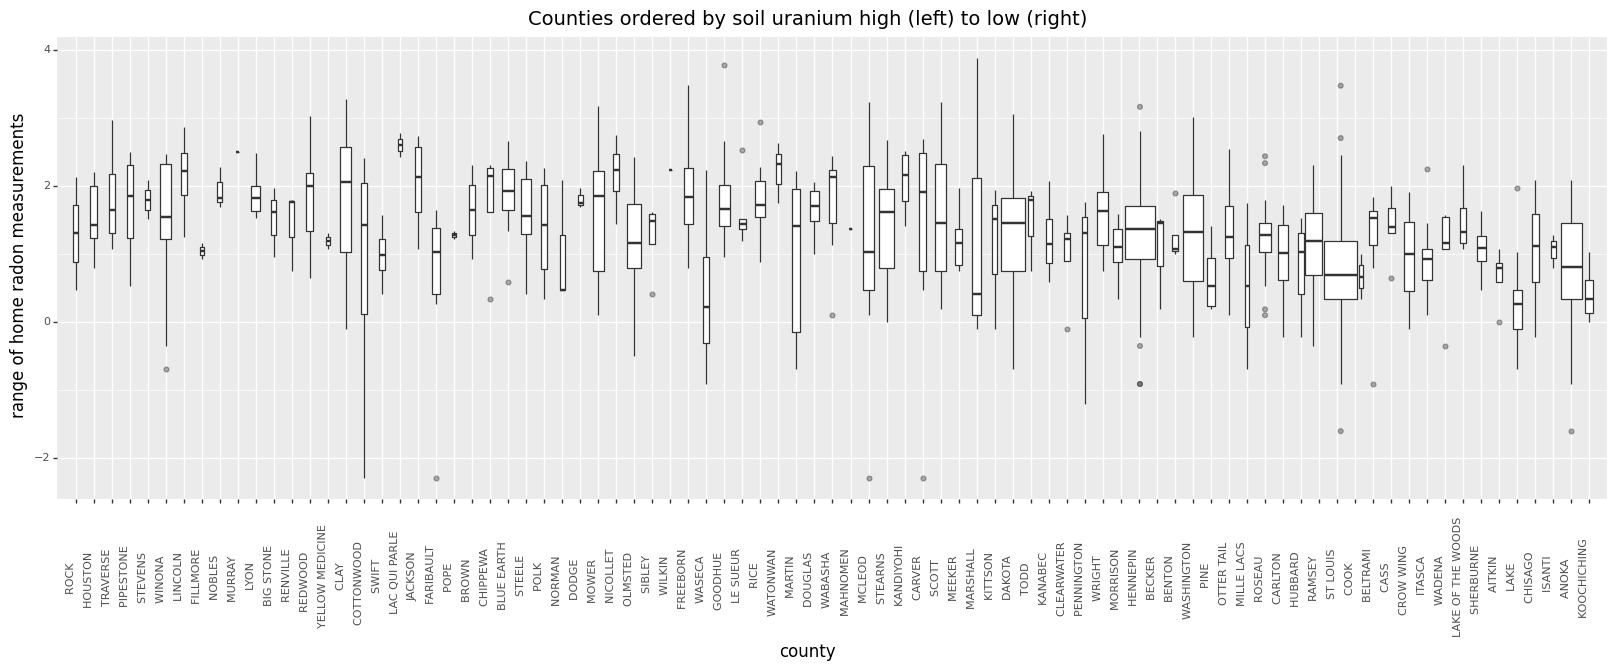

<ggplot: (8785532211664)>

In [14]:
uranium_desc = mn_counties.sort_values(by='log_uranium', ascending=False).reset_index()

(ggplot(mn_radon, aes(x='county',y='log_radon'))
    + geom_boxplot(width=2, varwidth=True, outlier_alpha=0.4)
    + scale_x_discrete(limits=uranium_desc['county'], expand=(0,1)) +  flip_xlabels
    + ggtitle("Counties ordered by soil uranium high (left) to low (right)")
    + ylab("range of home radon measurements")
    + theme(figure_size=(20,6))
)

## Linear regression review (chapters 2 and 3 of Gelman and Hill)

> Linear regression is a method that summarizes how the average values of a numerical outcome variable vary over subpopulations defined by linear functions of predictors. ... Regression can be used to predict an outcome given a linear function of these predictors, and regression coefficients can be thought of as comparisons across predicted values or as comparisons among averages in the data. </br>_Gelman and Hill, chapter 3_

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression#Formulation) models the relationship between a scalar response and one or more explanatory variables.

<img width="190" alt="Linear least squares example2" align="right" style="vertical-align:middle;margin:0px 50px"
     src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Linear_least_squares_example2.png/190px-Linear_least_squares_example2.png">

In linear regression, the observations (red) are assumed to be the result of random deviations (green) from an underlying relationship (blue) between a dependent variable (y) and an independent variable (x).

A [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) is a model which relates
a pair of sample points, an  _independent variable_ x, and a _dependent variable_ y.
The adjective simple refers to the fact that the outcome variable is related to a single predictor.
The model finds a linear function (a non-vertical straight line) that,
as accurately as possible, predicts the dependent variable values as a function of the independent variable.  (Geometry review: a straight line is defined by its _intercept_ on the x-axis and _slope_, i.e. $y = a + b x$)

**Linear regression:  two ways to write the model**

The goal of inference is to learn from incomplete or imperfect data.
In the simple linear regression model, the error term $\epsilon$ accounts for imperfect measurments of the data.

$
y_i = \alpha \, + {\beta}\,x_i + {\epsilon}_i
$
where the errors ${\epsilon}_i$ have independent normal distributions with mean $0$ and standard deviation $\sigma$.

An equivalent representation is

$
y_i ∼ \mathrm{N}(\alpha + \beta\,\mathrm{X}_i,\, \sigma^2), \ \ \ \mathrm{for}\ i=1, ..., n
$

The corresponding Stan statement is

```
y ~ normal(alpha + beta * x, sigma);
```

Stan provides [vectorized](https://mc-stan.org/docs/functions-reference/vectorization.html#vectorization) versions of all univariate probability distrions.
This statement is far more efficient than using a `for` loop over all $x_i$ and $y_i$ pairs.


**Simple linear regression model in Stan**

The simple linear regression with a single predictor and a slope and intercept coefficient and normally distributed noise is the first model discussed in the [Stan User's Guide Regression Models chapter](https://mc-stan.org/docs/stan-users-guide/linear-regression.html).

```
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}
```

## Best Practice #2: start with a simple model

Starting from a simple model ensures that there is a good baseline
against which to measure performance.
Gelman and Hill start from a simple linear regression which models the relationship between
the log radon measurement and the floor on which this measurement was taken.

The **complete pooling** model pools all measurements from all counties.
While it's possible to fit this model in Stan, we can also do this in plotnine by adding
[plotnine.geom.geom_smooth(method="lm")](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_smooth.html#plotnine.geoms.geom_smooth)
to the earlier scatter plot of radon measurements by floor.
The black line is the estimated mean and the the grey margins indicate the amount of variance.

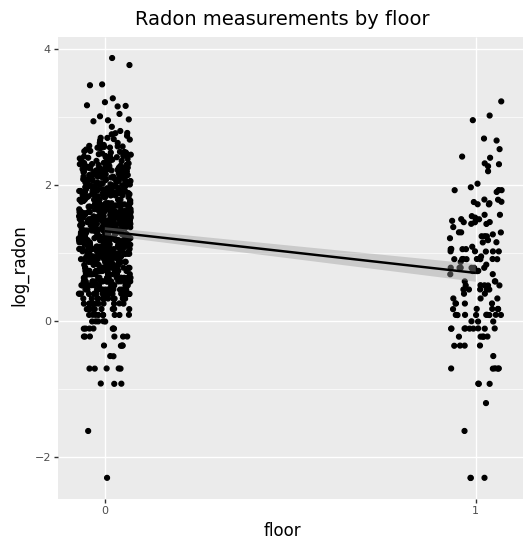

<ggplot: (8785600341270)>

In [15]:
plot_radon_floor +  geom_smooth(method='ols')

If we add faceting to this plot, we are fitting 85 individual regressions.  As noted above, most of the
measurements are taken at the basement level. Given the sparsity of the data, there are 25 counties which
have no measurements taken at the ground floor.

In [16]:
print(f'Number of counties: {mn_radon.county.nunique()}')
print(f'Counties with observations from both basement and ground floors: {len(mn_radon[mn_radon["floor"] == 1]["county"].value_counts())}')


Number of counties: 85
Counties with observations from both basement and ground floors: 60


When we use faceting to run the per-county regressions, the trend line is absent when there is no information on the ground floor; the resulting estimate is simply the average radon measurement of houses in that county.
For the remaining counties, most of which have very few measurments, in several instances, e.g., counties "Lyon" and "Redwood", the regression line between floor 0 and 1 has a positvie slope; in contrast to the complete pooling model. This goes against what we know about how radon enters the home.

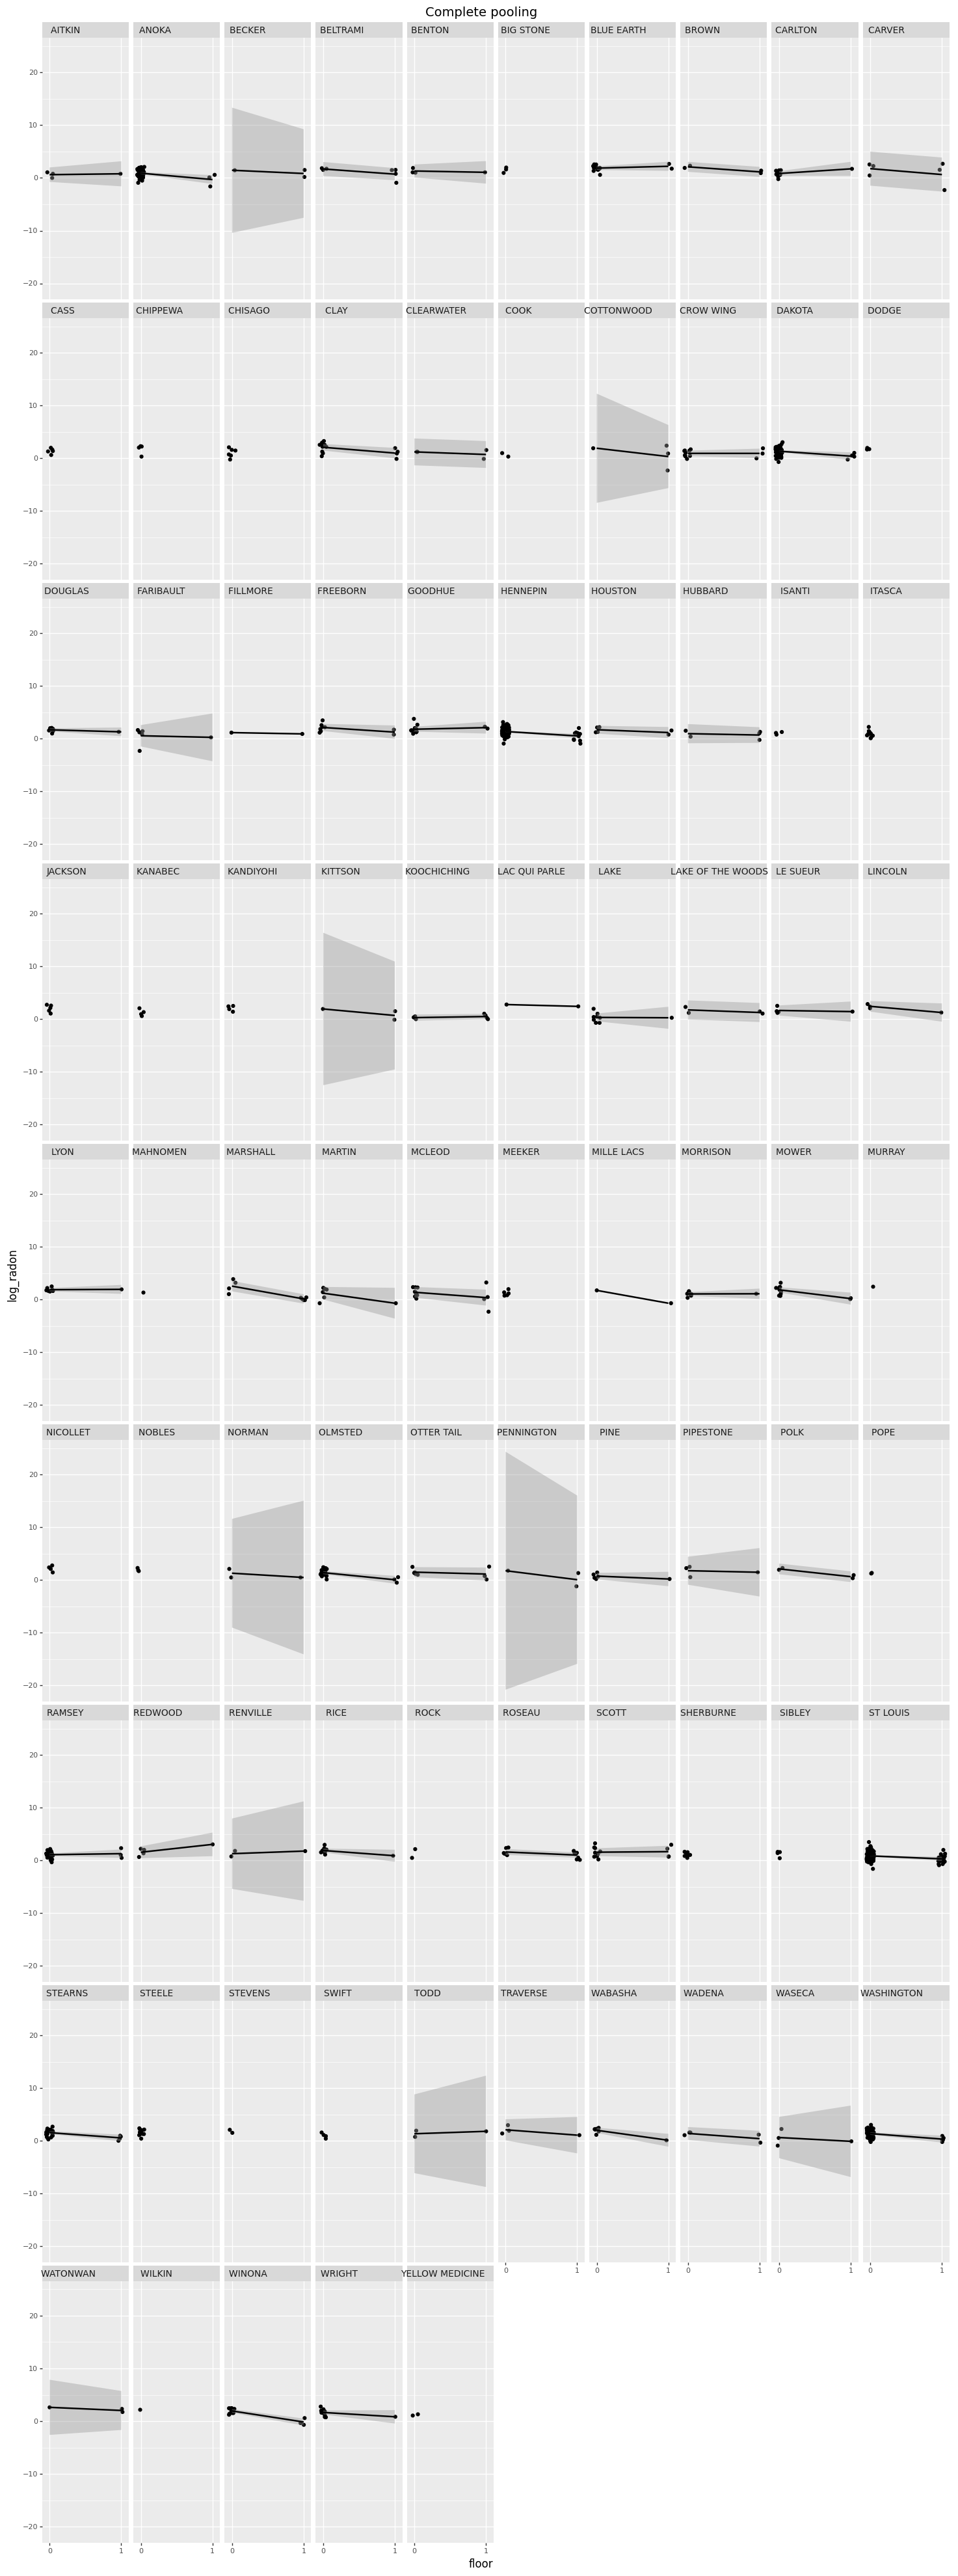

<ggplot: (8785600202253)>

In [17]:
ggplot(mn_radon, aes('floor', 'log_radon')) + geom_jitter(width=0.05) + theme(figure_size=(18,50)) +\
 ggtitle("Complete pooling") + scale_x_continuous(breaks=range(0,2), minor_breaks=[]) +\
 geom_smooth(method='ols') + facet_wrap('county')

### Simple linear regression in Stan with one predictor:  complete pooling model

The complete pooling model is one which doesn't use county information, that is, all counties are the same, and it fits a single regression line to all 919 observations in the dataset. 
The Stan model in the ARM repository corresponds to the simple linear regression model above,
except that it adds a weak prior on the variance term `sigma`.

We create a [CmdStanModel](https://mc-stan.org/cmdstanpy/api.html#cmdstanmodel) object from the Stan program file
[radon_complete_pool.stan](https://github.com/stan-dev/example-models/blob/master/ARM/Ch.12/radon_complete_pool.stan).

In [18]:
complete_pooling_model = CmdStanModel(stan_file=os.path.join('stan', 'radon_complete_pool.stan'))
print(complete_pooling_model.code())

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  sigma ~ normal(0, 5);
  y ~ normal(alpha + beta * x, sigma);
}




We assemble a Python dictionary which contains the definitions of the data block variables.

In [19]:
radon_data = {"N": len(mn_radon), "x": mn_radon.floor.astype(float), "y": mn_radon.log_radon}

We call the model's [sample](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample)
method which runs Stan's NUTS-HMC sampler.
The results are returned in the form of a
[CmdStanMCMC](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanMCMC) container object which
provides methods to summarize and diagnose the model fit and accessor methods to access the entire sample or individual items.

In [20]:
complete_pooling_fit = complete_pooling_model.sample(data=radon_data)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

The CmdStanMCMC object provides accessor methods which return the set of draws for each model variable.

+ [draws] returns the entire sample as either a 2D or 3D numpy.ndarray.

+ [draws_pd] returns the entire sample as a
a [pandas.Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

+ [draws_xr] returns an [xarray Drawset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

+ [stan_variable](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanMCMC.stan_variable) method
returns a structured [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html),
and 
[stan_variables](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanMCMC.stan_variables)
returns a Python dict from variable names to numpy.ndarrays.

Because we are going to be plotting the results with plotnine, we use the `draws_pd` method to extract the model parameters `alpha`, `beta`, and `sigma`.

In [21]:
pool_pd = complete_pooling_fit.draws_pd(vars=['alpha', 'beta', 'sigma'])
pool_stats = pool_pd.describe()
pool_stats.round(2)

,beta,alpha,sigma
count,4000.00,4000.00,4000.00
mean,-0.61,1.33,0.82
std,0.08,0.03,0.02
min,-0.85,1.21,0.77
25%,-0.66,1.31,0.81
50%,-0.61,1.33,0.82
75%,-0.56,1.35,0.84
max,-0.36,1.43,0.91


Another, more computationally expensive way to get these summary statistics is to call the [CmdStanMCMC.summary](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanMCMC.summary) method.
This returns a DataFrame of summary statistics for total joint log probability lp__ and all model variables,
plus diagnostic statistics on the
[effective sample size](https://mc-stan.org/docs/reference-manual/effective-sample-size.html)
and [R_hat](https://mc-stan.org/docs/reference-manual/notation-for-samples-chains-and-draws.html#potential-scale-reduction), the potential scale reduction factor.

In [22]:
complete_pooling_fit.summary().round(2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-280.77,0.03,1.26,-283.19,-280.44,-279.40,1905.74,3788.75,1.0
alpha,1.33,0.00,0.03,1.28,1.33,1.38,2397.50,4766.41,1.0
beta,-0.61,0.00,0.08,-0.74,-0.61,-0.49,2600.83,5170.63,1.0
sigma,0.82,0.00,0.02,0.79,0.82,0.86,3076.81,6116.92,1.0


We plot the regression line using the mean estimate for `alpha` and `beta` in blue, and plot the regression lines for 50 draws from the posterior.

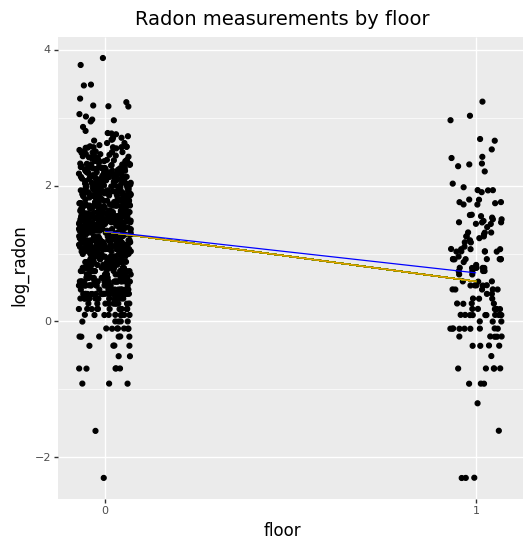

<ggplot: (8785550326068)>

In [23]:
plot_stan_fit = plot_radon_floor

for n in range(50):
    idx = random.randrange(0,4000)
    plot_stan_fit = plot_stan_fit + stat_function(
        fun=lambda x: pool_pd.alpha.iloc[idx] + pool_pd.beta.iloc[idx]*x,
        color='green'
        )
    
    plot_stan_fit = plot_stan_fit + stat_function(
        fun=lambda x: pool_pd.alpha.iloc[idx] + pool_pd.beta.iloc[idx]*x,
        color='orange'
        )
    
plot_stan_fit = plot_stan_fit + stat_function(
    fun=lambda x: pool_stats.alpha['mean'] + pool_stats.beta['mean']*x,
    color='blue'
)
plot_stan_fit

### Simple linear regression in Stan:  no pooling model

The simple no-pooling model as described in Gelman and Hill chapter 12.3
does not pool the estimates for the intercept term `alpha`
but it does completely pool estimates for the slope coefficient `beta`,
i.e., `beta` has the same value across all groups,
and also assumes the residual variance is the same within each group.

$
y_i = \alpha_{j[i]} \, + {\beta}\,x_i + {\epsilon}_i
$
where $j = 1 \ldots 85$

Coding this model in Stan requires the following modifications to the complete pooling model

* we introduce data variable `J`, the number of counties.
* we introduce data variable `county`, the array of per-house county ids.
* we change `alpha` from a scalar to a vector of length is `J`, the number of counties.
* we compute an intermediate variable `eta` so that we can continue to use the
vectorized form of the sampling statement.

In [24]:
logger = get_logger().setLevel(logging.WARN)
no_pooling_model = CmdStanModel(stan_file=os.path.join('stan', 'radon_no_pool.stan'))
print(no_pooling_model.code())

data {
  int<lower=1> N;  // observations
  int<lower=1> J;  // counties
  array[N] int<lower=1, upper=J> county;
  vector[N] x;
  vector[N] y;
}
parameters {
  real beta;
  vector[J] alpha;
  real<lower=0> sigma;
}
model {
  vector[N] eta;
  for (i in 1:N)
    eta[i] = alpha[county[i]] + beta * x[i];
  sigma ~ normal(0, 5);
  y ~ normal(eta, sigma);  
}



In [26]:
radon_data["J"] = 85
radon_data["county"] = mn_radon.county_code

no_pooling_fit = no_pooling_model.sample(data=radon_data)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [27]:
no_pool_pd = no_pooling_fit.draws_pd(vars=['alpha'])
no_pooling_fit.summary().round(2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-204.22,0.19,7.18,-217.04,-203.74,-193.14,1354.82,1024.05,1.0
beta,-0.72,0.00,0.07,-0.84,-0.72,-0.60,3045.17,2301.72,1.0
alpha[1],0.84,0.01,0.37,0.23,0.83,1.44,5249.16,3967.62,1.0
alpha[2],0.87,0.00,0.11,0.70,0.88,1.05,6335.97,4789.09,1.0
alpha[3],1.52,0.01,0.45,0.79,1.52,2.29,4540.29,3431.82,1.0
...,...,...,...,...,...,...,...,...,...
alpha[82],2.24,0.01,0.77,0.99,2.24,3.49,5165.38,3904.29,1.0
alpha[83],1.62,0.00,0.21,1.27,1.62,1.97,4719.05,3566.93,1.0
alpha[84],1.64,0.00,0.22,1.28,1.65,1.99,4462.00,3372.64,1.0


In [30]:
mean = no_pool_pd.mean()
upper = mean + no_pool_pd.std()
lower = mean - no_pool_pd.std()
no_pool_alpha_pd = pd.concat([mn_counties['county'],
          mean.to_frame("mean").reset_index(drop=True),
          upper.to_frame("upper").reset_index(drop=True),
          lower.to_frame("lower").reset_index(drop=True)], axis=1)
no_pool_alpha_pd

,county,mean,upper,lower
0,AITKIN,0.838859,1.210999,0.466720
1,ANOKA,0.874865,0.981664,0.768066
2,BECKER,1.521186,1.969240,1.073133
3,BELTRAMI,1.552552,1.846521,1.258583
4,BENTON,1.436998,1.809856,1.064140
...,...,...,...,...
80,WATONWAN,2.711303,3.151847,2.270759
81,WILKIN,2.239704,3.005319,1.474089
82,WINONA,1.622389,1.836667,1.408111
83,WRIGHT,1.643011,1.858453,1.427570


In [31]:
# plot alpha plus/minus 1 sd to show rel between amount of data and uncertainty
no_pool_alpha = []
for i in range(len(mn_counties)):
    vals = [mn_counties['county'][i], 
            no_pool_stats.iloc[1, i], 
            no_pool_stats.iloc[1, i] + no_pool_stats.iloc[2, i],
            no_pool_stats.iloc[1, i] - no_pool_stats.iloc[2, i]]
    no_pool_alpha.append(vals)
no_pool_alpha_pd = pd.DataFrame(no_pool_alpha, columns=['county', 'mean', 'upper', 'lower'])

NameError: name 'no_pool_stats' is not defined

In [ ]:
# get sort order
pop_desc = county_df.sort_values(by='obs', ascending=False).reset_index()

# visualize
(ggplot()
 # Range strip
 + geom_segment(
     no_pool_alpha_pd,
     aes(x='county', xend='county', y='lower', yend='upper'),
     size=1.4,
     color='darkblue',
     alpha=0.5,
 )
 + geom_point(no_pool_alpha_pd, aes(x='county', y='mean'))
 + geom_hline(yintercept=pool_stats.alpha[1], color='darkorange', size=1.5)
 + scale_x_discrete(limits=pop_desc['county'])
 + ggtitle("No pooling model estimates for alpha (basement log_radon level)")
 + ylab("central 67% interval") + xlab("ordered by observations per county, desc")
 + flip_xlabels
 + theme(figure_size=(20,4)) 
)

The complete pooling model ignores the county level variance.  The no-pooling model overstates the variance between counties.

## Multilevel models

Multilevel models are extensions of regression in which data are structured in groups and coefficients can vary by group, and both the group-level and individual level co-efficients are modeled.
For a simple linear regression model with a single predictor, the complete-pooling model
estimates two parameters:  the intercept and slope of the regression line.
A multilevel regression model has group-level parameters
which provide partial pooling of information across the groups,
and which themselve can be modeled.
There are three possible ways to pool information:

- varying slope, single intercept

- single slope, varying intercept

- individual slope, individual intercept

As we add more predictors to the model, the number of modeling choices increases.

For the radon dataset, houses are located within counties, and different counties have different geological profiles, i.e., different amounts of soil uranaium.  There are several ways to partially pool this information.

**Model 2A:  verying slope, single intercept** same baseline, different counties have different floor effects

**Model 2B: single slope varying intercept** floor effect is the same, different counties have different baseline

**Model 2C: varying slope, varying intercept** lots of little indices everywhere

## Appendix A:  Data preparation using Pandas.

The steps required to convert the CSV files from the Gelman and Hill ARM website
into the data structures used in this analysis:

+ Merge the county-level soil uranium level measurment into the home radon data.
+ Put both outcome and predictors on the log scale, following Gelman and Hill, chapter 4, section 12.
+ Restrict the dataset to Minnesota.
+ Aggregate county-level information

Pandas objects contain structured arrays which are labeled by
[Index objects](https://pandas.pydata.org/docs/reference/indexing.html).
A [Series](https://pandas.pydata.org/docs/reference/series.html) object 
manages 1-D arrays and a [DataFrame](https://pandas.pydata.org/docs/reference/frame.html)
is a 2-D size-mutable, table, allowing for heterogenous columns.
These index labels are used to perform database-like select, join, and group-by operations.
However, sometimes we need to access just the data, not the index labels.
Most data is backed by an NumPy [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray).
The [array](https://pandas.pydata.org/docs/reference/api/pandas.Series.array.html) property
returns the underlying numpy.ndarray of the Index or Series object.

**Extract relevant columns from CSV as pandas DataFrame**

We leverage the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function
to extract the information we need from the raw CSV files with the following non-default arguments

* parameter `usecols` allows us to extract just the relevant columns for this analysis.
* parameter `skipinitialspace` strips out initial whitespace from the data.

Once instantiated, we call the [convert_dtypes method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html) on the newly instantiated DataFrame so that we can do merge and join operations on all columns.

In [ ]:
df_radon = pd.read_csv(os.path.join('data','raw_radon.csv'),
    usecols=['state', 'stfips', 'floor', 'activity', 'county', 'cntyfips'],
    skipinitialspace=True,    # CSV file has spaces after delimiter, ignore them
).convert_dtypes()
print(f'Total records: {len(df_radon)}')
df_radon[:3]

In [ ]:
df_uranium = pd.read_csv(os.path.join('data','raw_uranium.csv'),
                        usecols=['stfips', 'ctfips', 'st', 'cty', 'Uppm'],
                        skipinitialspace=True,
                        ).drop_duplicates().convert_dtypes()
df_uranium[:3]

**Combine datasets**

[FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) are numbers which uniquely identify geographic areas. Both datasets have codes for the state and county ids, but these need to be combined to get a national-level county FIPS code.   In order to do a database-style join on the two tables, we need to

1. add acommon key to both tables
2. add the county-level soil uranium levels to the radon survey via the [DataFrame.merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.


In [ ]:
df_radon['fips'] = df_radon.stfips*1000 + df_radon.cntyfips
df_uranium['fips'] = df_uranium.stfips*1000 + df_uranium.ctfips

df_radon = df_radon.merge(df_uranium[['fips', 'Uppm']], on='fips')
df_radon[:3]

**Put data on log scale**

Following Gelman and Hill chapter 4, section 4, we work with data on the log scale,
for two reasons

+ the outcome variable log_radon is always positive.
+ it provides modeling flexibility.

We know from geology that both radon measurements and soil uranium levels are always greater than zero,
however a few radon measurements in the EPA dataset are 0.
In order to be able to work with these measurements on the log scale, we replace 0 with 0.1,
which corresponds to a low radon level (following Gelman and Hill).

In [ ]:
df_radon['radon'] = df_radon.activity.apply(lambda x: x if x > 0. else 0.1)
df_radon['log_radon'] = np.log(df_radon['radon'])

df_radon['uranium'] = df_radon.Uppm.apply(lambda x: x if x > 0. else 0.1)
df_radon['log_uranium'] = np.log(df_radon['uranium'])
df_radon[:3]

**Cleanup**

Remove the columns which contain redundant information.

In [ ]:
df_radon.drop(columns=['stfips', 'activity', 'cntyfips', 'Uppm', 'fips', 'radon', 'uranium'], inplace=True)

**Restrict dataset to Minnesota**

In order to work with just the data from Minnesota, we use a 
use a conditional expression to [filter specific rows of a dataframe](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html#how-do-i-filter-specific-rows-from-a-dataframe), combined with operation [reset_index(drop=True)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index) so that the rows are indexed starting from 0.

In [ ]:
mn_radon = df_radon[df_radon['state']=='MN'].reset_index(drop=True)
mn_radon[:3]

**Add 1-based index code for MN counties**

The data inputs to a Stan model include a 1-based county index for each observation.
In order to do this we need to first get a sorted list of county names and then convert these to category code.

In [ ]:
counties = mn_radon.county.unique()
mn_radon['county_code'] = mn_radon.county.astype(
    pd.api.types.CategoricalDtype(categories=counties)
).cat.codes + 1  ## Stan indexes from 1
mn_radon[:5]

**Create auxiliary dataset of per-county information**

County-level information includes the number of observations taken in that county as well as the soil uranium level.
In order to easily visualize this information using plotnine, we create a secondary pandas.Dataframe object with per-county leel information.

In [ ]:
mn_uranium = mn_radon.iloc[mn_radon.county.drop_duplicates().index].reset_index(drop=True)
mn_uranium = mn_uranium.drop(columns=['floor', 'log_radon'])

The [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html) method returns a Series containing counts of unique values,
We add these to the county-level dataframe.

In [ ]:
mn_uranium['obs'] = mn_radon.value_counts(subset='county', sort=False).array
mn_uranium

**Save as CSV files**

These files are already part of this notebook, therefore calls to the  [pandsa.to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html?highlight=to_csv#pandas.DataFrame.to_csv) method have been commented out.

In [ ]:
# uncomment as needed
mn_radon.to_csv(r'mn_radon.csv', index=False)
mn_uranium.to_csv(r'mn_uranium.csv', index=False)

## Appendix B:  efficient Stan models

* it uses the more efficient [`normal_id_glm` distribution](https://mc-stan.org/docs/functions-reference/normal-id-glm.html) instead of the `normal` distribution. The `normal_id_glm` distribution is optimized for simple linear regresion models and takes as arguments:

    + a vector of observations of length `N`
    + a matrix of predictors of size `[N, M]`
    + the scalar intercept parameter
    + a vector of length `M` regression coefficients
    + variance parameter


In [ ]:
# do something

## Appendix C:  data viz with plotnine


A grammar of graphics defines a plot in terms of:

+ a default dataset and set of mappings from dataset variables to graph elements called "aesthetics",
+ one or more layers, with each layer having
   + one geometric object ("geoms")
   + one statistical transformation ("stats") 
   + one position adjustment
   + (optionally) one dataset and set of aesthetic mappings,
+ one scale for each aesthetic mapping used,
+ a coordinate system,
+ the facet specification.

Although this is a beautiful abstraction which allows us to build complex visualizations
by adding layers to the plot,  for any given implementation, there are limits compositionality.
The choice of coordinate systems determines the the kinds of geometric objects,
and the kinds of geometric objects used determines the set of aesthetics.

In plotnine, a ggplot object takes as arguments a [pandas](https://pandas.pydata.org/docs/index.html)
DataFrame object and a mapping between Python variables and graph elements, denoted by argument `aes`.
Theme objects control the overall layout and look and feel.
Like ggplot2, plotnine provides a rich set of geoms
and fine-grained control over all aspects of the plot layout,
leading to more effective statisticial communication.

In [ ]:
# do something else